In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from scipy.signal import butter, filtfilt, freqz
from scipy import signal
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem, zscore
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
import pickle
from skimage import io
import glob

/home/users/ilanazs/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
fly_num = 'fly_240'
func_path = f'/oak/stanford/groups/trc/data/Ilana/2P/data/{fly_num}/'
later_dir = '/oak/stanford/groups/trc/data/Ilana/2P/data/later/'


In [187]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path,'func_0', 'visual')

### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd1, t)

# *100 puts in units of 10ms, which will match fictrac
st_10ms = [int(stimulus_start_times[i]*100) for i in range(len(stimulus_start_times))]

# get 1ms version to match neural timestamps
st_ms= [i*10 for i in st_10ms]
starts_loom = st_10ms

loading photodiode data... done


In [188]:
####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'func_0', 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'dRotLabX']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'dRotLabX': short = 'X'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
fictrac_timestamps = np.arange(0,expt_len,resolution)

In [189]:
def extract_traces(fictrac, stim_times, pre_window, post_window, val=None):
    traces = []
    for i in range(len(stim_times)):
        if val != None:
            trace = fictrac[val][stim_times[i]-pre_window:stim_times[i]+post_window]
        else:
            trace = fictrac[stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

In [190]:
###########################################
### Extract Stimulus Triggered Behavior ###
###########################################

pre_window = 200
post_window = 300
# avg_around = 20
stim_time = 100
# window = np.arange(-pre_window,post_window)

behavior_traces = {}
mean_trace = {}
sem_trace = {}
behavior_traces,mean_trace,sem_trace = brainsss.extract_traces(fictrac['Y'], starts_loom, pre_window, post_window)
# behavior_traces_QC,mean_trace_QC,sem_trace_QC = extract_traces(fictrac['Y'], null_times, pre_window, post_window)


In [191]:
starts_loom_ms = [n*10 for n in starts_loom]

In [192]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'func_0','clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [193]:
timestamps = brainsss.load_timestamps(os.path.join(func_path,'func_0', 'imaging'))

Trying to load timestamp data from hdf5 file.
Success.


In [194]:
bin_start = -500; bin_end = 2000; bin_size = 100 #ms
neural_bins = np.arange(bin_start,bin_end,bin_size)

In [195]:
%%time
data_dict = {}
data_dict['signals'] = all_signals
data_dict['timestamps'] = timestamps
data_dict['event_times'] = starts_loom_ms
data_dict['bins'] = neural_bins
data_dict['behavior'] = behavior_traces
data_dict['cluster_labels'] = cluster_labels


later_path = os.path.join(later_dir, fly_num+'_dic.pkl')

with open(later_path, 'wb') as file:
    pickle.dump(data_dict, file)

CPU times: user 150 ms, sys: 1.17 s, total: 1.32 s
Wall time: 3.62 s


In [3]:
for x in sorted(os.listdir(later_dir)):
    if 'dic' in x:
        print(x)

fly_208_dic.pkl
fly_209_dic.pkl
fly_210_dic.pkl
fly_217_dic.pkl
fly_218_dic.pkl
fly_227_dic.pkl
fly_228_dic.pkl
fly_234_dic.pkl
fly_240_dic.pkl
total_dict.pkl


In [4]:
%%time
total_path = os.path.join(later_dir, 'total_dict.pkl')
if os.path.exists(total_path)==False:
    print("Making total dict")
    total_data_dict = {}

    for x in sorted(os.listdir(later_dir)):
        if 'dic' in x:
            fly_name= x[4:7]
            temp_path = os.path.join(later_dir, x)
            with open(temp_path, 'rb') as file:
                dic = pickle.load(file)
                total_data_dict[fly_name] = dic
    with open(total_path, 'wb') as file:
        pickle.dump(total_data_dict, file)
else:
    print("Loading total dict")
    with open(total_path, 'rb') as file:
        total_data_dict = pickle.load(file)

Loading total dict
CPU times: user 743 ms, sys: 9.09 s, total: 9.84 s
Wall time: 60 s


In [5]:
total_data_dict.keys()

dict_keys(['208', '209', '210', '217', '218', '227', '228', '234', '240'])

In [6]:
%%time
total_behave_struct = {}
total_behave_norm = {}
total_behave_norm1 = {}
total_behave_norm2 = {}
total_behave_norm3 = {}
shape = 196 #this is hard coded to be the smallest but i gotta figure this shit out better
for x in sorted(os.listdir(later_dir)):
    if 'dic' in x and 'total' not in x:
        fly_name= x[4:7]
        temp_path = os.path.join(later_dir, x)
        with open(temp_path, 'rb') as file:
            struct = pickle.load(file)
            total_behave_struct[fly_name] = struct['behavior'][:shape,:]
            temp = struct['behavior']
            pre_v = temp[:,100:200]
    #         print(np.shape(pre_v))
    #         pre_v = np.asarray(pre_v)
            mean_pre = np.mean(pre_v)
            std_pre = np.std(pre_v)
            temp_norm = (temp-mean_pre)/std_pre
            total_behave_norm[fly_name] = temp_norm[:shape,:]
            temp_norm1 = (temp-mean_pre)/mean_pre
            total_behave_norm1[fly_name] = temp_norm1[:shape,:]
            temp_norm2 = temp/mean_pre
            total_behave_norm2[fly_name] = temp_norm2[:shape,:]
            temp_z = zscore(temp, axis=1)
            total_behave_norm3[fly_name] = temp_z[:shape,:]
print(total_behave_struct.keys())
# total_behave = np.asarray(np.mean(total_behave, axis=0))
# total_behave_path = os.path.join(later_dir, 'total_behaves.npy')
# np.save(total_behave_path, total_behave)

dict_keys(['208', '209', '210', '217', '218', '227', '228', '234', '240'])
CPU times: user 832 ms, sys: 9.07 s, total: 9.91 s
Wall time: 50.8 s


(500,)
(500,)


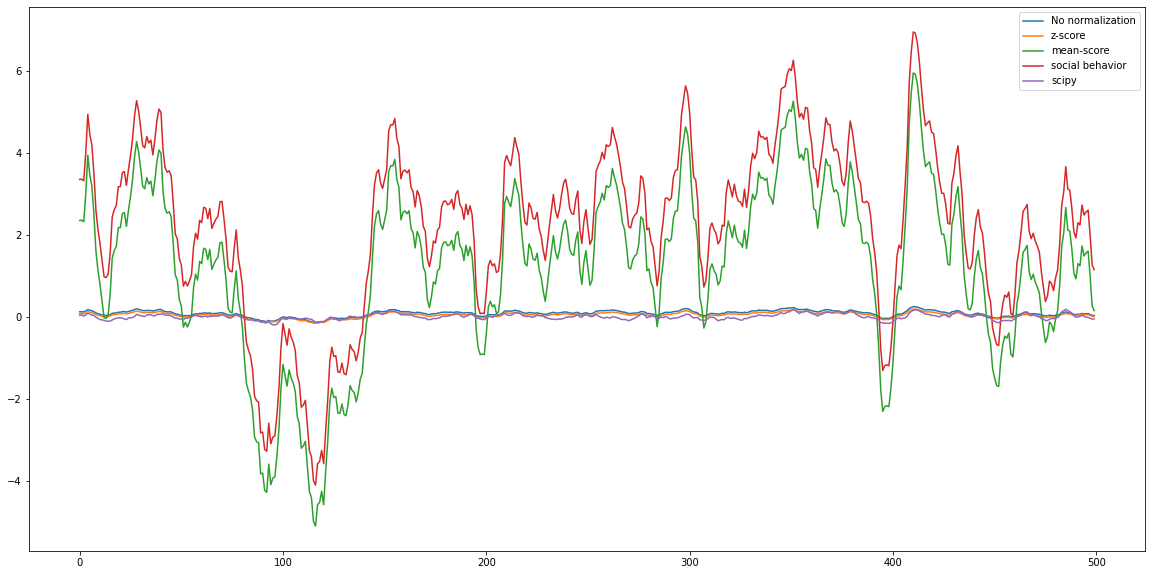

In [7]:
fly = "217"

a=np.mean(total_data_dict[fly]['behavior'], axis=0)
print(np.shape(a))
b=np.mean(total_behave_norm[fly], axis=0)
print(np.shape(b))
c=np.mean(total_behave_norm1[fly], axis=0)
d=np.mean(total_behave_norm2[fly], axis=0)
e=np.mean(total_behave_norm3[fly], axis=0)
fig, ax = plt.subplots(figsize=(20,10))
# fig.subplots(figsize=(10,10))
ax.plot(a.T, label='No normalization')
ax.plot(b.T, label='z-score')
ax.plot(c.T, label='mean-score')
ax.plot(d.T, label='social behavior')
ax.plot(e.T, label='scipy')
ax.legend()

In [8]:
def plot_flies(struct):
    fig, ax = plt.subplots(figsize=(20,10))
    for key in struct:
        f=np.mean(struct[key], axis=0)
    #     print(np.shape(f))
        ax.plot(f.T, label=key)
        ax.legend()
    # # ax.plot(np.mean(total_behave, axis=1).T)

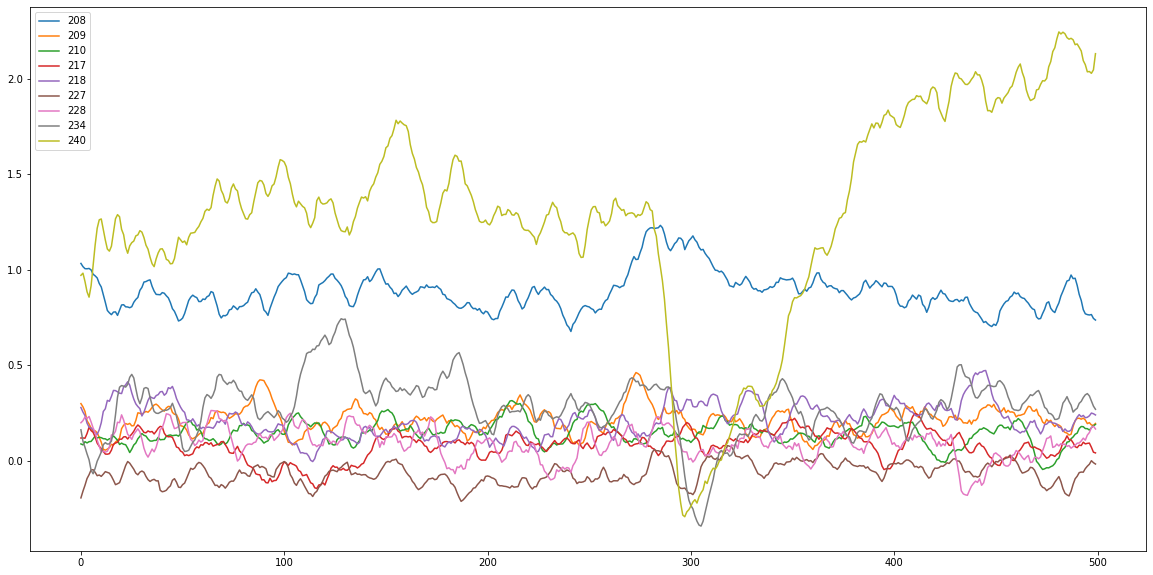

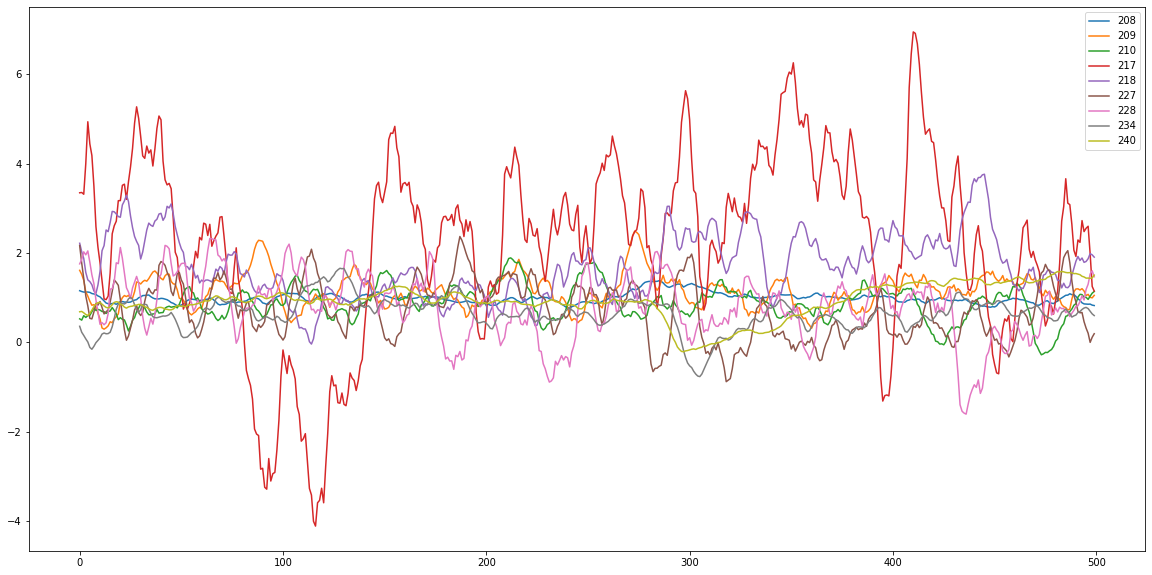

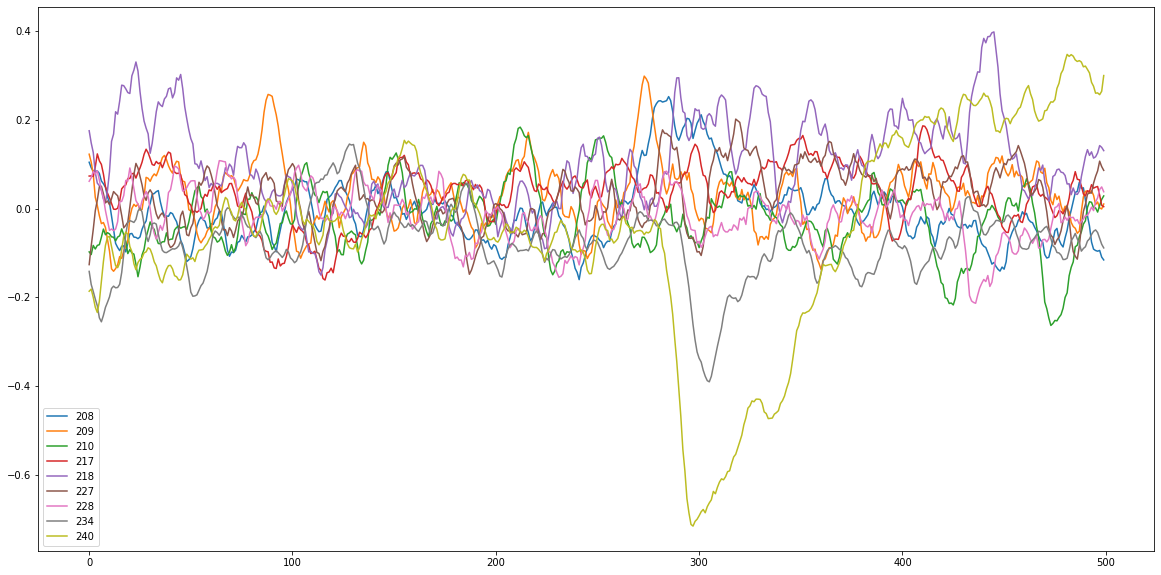

In [9]:
plot_flies(total_behave_struct)
plot_flies(total_behave_norm2)
plot_flies(total_behave_norm)

In [10]:
def plot_trace(behavior_trace, pre_window, post_window, stim_time, ax=None, fig=None):
    mean_trace = np.mean(behavior_trace, axis=0)
    sem_trace = scipy.stats.sem(behavior_trace, axis=0)
    color='b'
    
    if ax==None:
        fig, ax = plt.subplots(figsize=(10,10))
        color='k'
#     plt.figure(figsize=(10,10))
    ax.plot(mean_trace,color=color,linewidth=3)
    ax.fill_between(np.arange(np.shape(mean_trace)[0]),mean_trace-sem_trace, mean_trace+sem_trace, color='k',alpha=0.3)
    ax.axvline(pre_window,color='k',linestyle='--',lw=2)
    ax.axvline(pre_window+stim_time,color='k',linestyle='--',lw=2)
    ax.set_ylim(-0.5, 3.5);
    return fig, ax

In [11]:
def overall_behavior_array(struct):
    temp = []
    for key in struct:
        try:
            lst = struct[key]['traces']
        except IndexError:
            lst = struct[key]
#         print(np.shape(lst))
        temp.append(lst)
    temp = np.vstack(temp)
#     print(np.shape(temp))
#     temp = np.mean(temp, axis=0)
    return np.asarray(temp)

In [12]:
total = overall_behavior_array(total_behave_struct)
total_norm = overall_behavior_array(total_behave_norm2)

(None, <AxesSubplot:>)

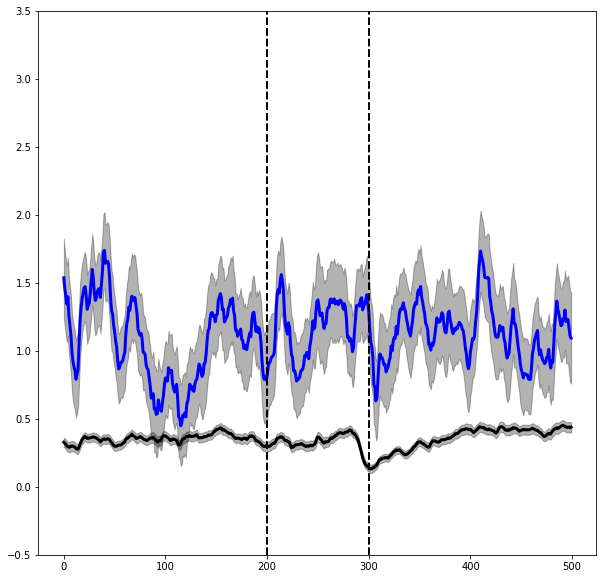

In [13]:
pre_window = 200
post_window = 300
stim_time = 100
fig, ax = plot_trace(total, pre_window, post_window, stim_time)
plot_trace(total_norm, pre_window, post_window, stim_time, ax=ax)

In [14]:
def get_vals_for_analysis(tp_width_sec=0, trial_time_sec=0, before_stim_sec=0, pre_trial_window_sec=0, pre_trial_size_sec=0, post_trial_window_sec=0, post_trial_size_sec=0, thresh=0, fr=0):
        
    stim_end_sec = before_stim_sec + trial_time_sec
    
    stim_idx = int(before_stim_sec/tp_width_sec)
    stim_end_idx = int(stim_end_sec/tp_width_sec)
    pre_trial_window_idx = int(pre_trial_window_sec/tp_width_sec)

    # first val i use to make delta to compare change in vel
    first_val_end_idx = int(stim_idx - pre_trial_window_idx)
    first_val_start_idx = int(first_val_end_idx - (pre_trial_size_sec/tp_width_sec)) #only needed if you're averaging across a window, otherwise just start val is used

    # second val used to make delta
    second_val_start_idx = int(stim_idx + post_trial_size_sec/tp_width_sec)
    second_val_end_idx = int(second_val_start_idx + post_trial_window_sec/tp_width_sec)
    return stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx

In [15]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, method="gust")
    return y

In [16]:
def apply_butter_lowpass(behavior_traces, stim_idx, fr):
    # Filter requirements.
    order = 4
    fs = fr      # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Filter the data, and plot both the original and filtered signals.
    lpf_behavior = np.zeros((behavior_traces.shape[0], behavior_traces.shape[1] - stim_idx))

    for i in range(behavior_traces.shape[0]):
        lpf_behavior[i, :] = butter_lowpass_filter(behavior_traces[i,stim_idx:], cutoff, fs, order)

    return lpf_behavior

In [17]:
def get_speed_change(behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx):
    pre_tsi= first_val_start_idx-stim_idx
    pre_tei = first_val_end_idx-stim_idx
    post_tsi = second_val_start_idx-stim_idx
    post_tei = second_val_end_idx-stim_idx
    
    if first_val_start_idx!=first_val_end_idx:
        first_speed = np.mean(behavior[:,pre_tsi:pre_tei], axis = 1)
    else:
        first_val_start_idx = int(first_val_start_idx)
        first_speed = np.asarray(behavior[:,pre_tsi])

    if second_val_start_idx!=second_val_end_idx:
        second_speed = np.mean(behavior[:,post_tsi:post_tei], axis = 1)
    else: 
        second_speed = np.asarray(behavior[:,post_tsi])
    speed_change = second_speed-first_speed
    return speed_change

In [18]:
def get_trials(speed_change, thresh):
    decrease_trials = speed_change <-thresh
    decrease_idx = np.where(decrease_trials)
    increase_trials = speed_change>thresh
    increase_idx = np.where(increase_trials)
    flat_trials = np.logical_and(speed_change>-thresh, speed_change<thresh)
    flat_idx = np.where(flat_trials)
    return increase_trials, increase_idx, decrease_trials, decrease_idx, flat_trials, flat_idx

In [20]:
value_struct ={
    # the data is in 10ms, use this value to get the index if i use seconds
    "tp_width_sec": 0.01,
    "trial_time_sec": 1,
    "before_stim_sec": pre_window/100,
    # time in seconds between end of pre trial window and the stimulus time. 
    # when set to zero, the pre trial window ends when the stimulus is presented
    "pre_trial_window_sec": 0.5,
    # size of window that pre trial speed is averaged over, seconds, window ends at stimulus time
    # when 0 is a single val and not a window
    "pre_trial_size_sec": 0,
    # size of post trial speed average window, sec
    "post_trial_window_sec": 0.5,
    # post trial window at stim tiem + post trail delay
    # when 0 is a single val and not a window
    "post_trial_size_sec": 0,
    "thresh": 0.05,
    "fr": 100.00033694743087 
    #frame rate
    }

In [21]:
def make_traces(behavior, fr):
    increase_total= []
    decrease_total= []
    flat_total= []

    for fly in behavior:
        stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)
        lpf_behavior = apply_butter_lowpass(fly, stim_idx, fr)
        speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
        increase_trials,increase_idx, decrease_trials, decrease_idx, flat_trials, flat_idx = get_trials(speed_change, value_struct["thresh"])
        increase_traces = fly[increase_trials]
    #     print(np.shape(increase_traces))
    #     print(np.shape(increase_total))
        increase_total.append(increase_traces)
        decrease_traces = fly[decrease_trials]
    #     print(np.shape(decrease_traces))
        decrease_total.append(decrease_traces)
        flat_traces = fly[flat_trials]
    #     print(np.shape(flat_traces))
        flat_total.append(flat_traces)

    increase_total=np.vstack(np.asarray(increase_total))
    print(np.shape(increase_total))
    decrease_total=np.vstack(np.asarray(decrease_total))
    print(np.shape(decrease_total))
    flat_total=np.vstack(np.asarray(flat_total))
    print(np.shape(flat_total))
    return increase_total, decrease_total, flat_total

In [22]:
def separate_traces(behavior_struct, value_struct):

    increase_total= {}
    increase_trial_num = 0
    decrease_total= {}
    decrease_trial_num = 0
    flat_total= {}
    flat_trial_num = 0

    stim_idx, stim_end_idx, pre_trial_window_idx, first_val_end_idx, first_val_start_idx, second_val_end_idx, second_val_start_idx = get_vals_for_analysis(**value_struct)

    for key in behavior_struct:
        traces = behavior_struct[key]
        lpf_behavior = apply_butter_lowpass(traces, stim_idx, value_struct["fr"])
        speed_change = get_speed_change(lpf_behavior, stim_idx, first_val_start_idx, first_val_end_idx, second_val_start_idx, second_val_end_idx)
        increase_trials,increase_idx, decrease_trials, decrease_idx, flat_trials, flat_idx = get_trials(speed_change, value_struct["thresh"])
    #     print(increase_trials)
        increase_traces = traces[increase_trials]
        increase_trial_num += np.shape(increase_traces)[0]
        increase_total[key]={}
        increase_total[key]['traces'] = increase_traces
        increase_total[key]['idx'] = increase_idx
        decrease_traces = traces[decrease_trials]
        decrease_trial_num += np.shape(decrease_traces)[0]
        decrease_total[key]={}
        decrease_total[key]['traces'] = decrease_traces
        decrease_total[key]['idx'] = decrease_idx
        flat_traces = traces[flat_trials]
        flat_trial_num += np.shape(flat_traces)[0]
        flat_total[key]={}
        flat_total[key]['traces'] = flat_traces
        flat_total[key]['idx'] = flat_idx

    print(f"Increase trial number: {increase_trial_num}")
    print(f"Decrease trial number: {decrease_trial_num}")
    print(f"Flat trial number: {flat_trial_num}")
    return increase_total, decrease_total, flat_total

In [23]:
#normalized
inc_n_dict, dec_n_dict, flat_n_dict = separate_traces(total_behave_norm2, value_struct)
#non-normalized
inc_dict, dec_dict, flat_dict = separate_traces(total_behave_struct, value_struct)

Increase trial number: 858
Decrease trial number: 842
Flat trial number: 64
Increase trial number: 732
Decrease trial number: 738
Flat trial number: 294


In [24]:
def plotable_arrays(inc, dec, flat):
    inc_lst = overall_behavior_array(inc)
    dec_lst = overall_behavior_array(dec)
    flat_lst = overall_behavior_array(flat)
    return inc_lst, dec_lst, flat_lst

In [25]:
inc_n, dec_n, flat_n = plotable_arrays(inc_n_dict, dec_n_dict, flat_n_dict)
inc, dec, flat = plotable_arrays(inc_dict, dec_dict, flat_dict)

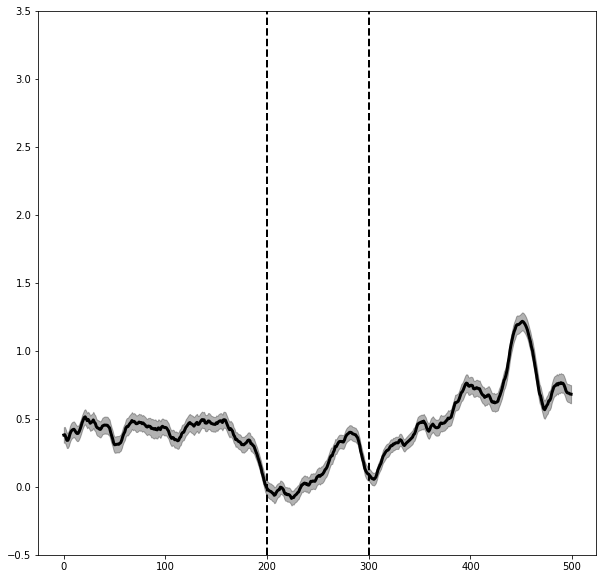

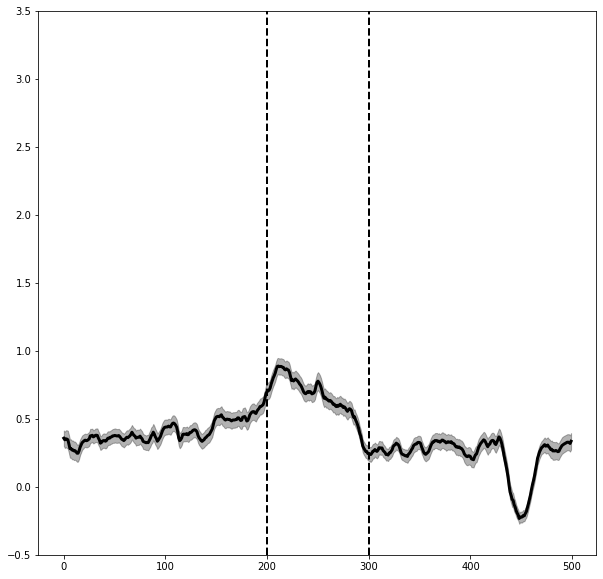

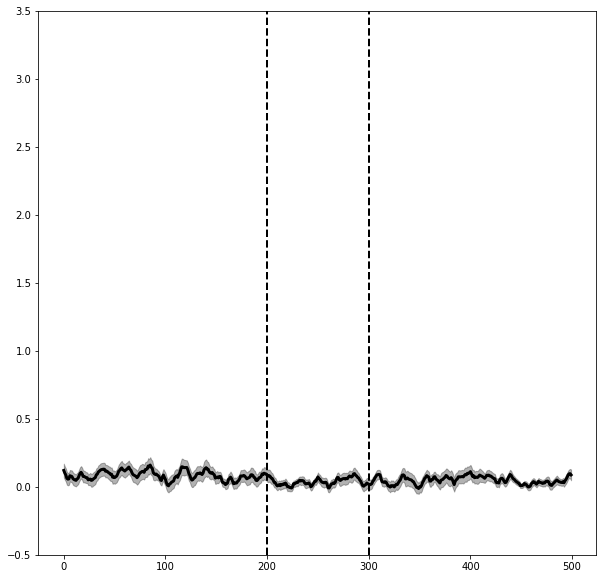

In [26]:
fig1,ax1 = plot_trace(dec, pre_window, post_window, stim_time)
# plot_trace(dec_n, pre_window, post_window, stim_time, ax=ax1)
# print(np.shape(dec_n))
fig2,ax2 = plot_trace(inc, pre_window, post_window, stim_time)
# plot_trace(inc_n, pre_window, post_window, stim_time, ax=ax2)
# print(np.shape(inc_n))
fig3,ax3 = plot_trace(flat, pre_window, post_window, stim_time)
# plot_trace(flat_n, pre_window, post_window, stim_time, ax=ax3)
# print(np.shape(flat_n))

In [27]:
def get_event_times_list(trials, event_times, ms=True):
    trials_idx = np.where(trials)
    trials_starts =[]
    for idx in trials_idx[0]:
        trials_starts.append(event_times[idx])
    if ms==True:
        trials_starts = [n*10 for n in trials_starts]
    print(np.shape(trials_starts))
    return trials_starts

In [28]:
total_data_dict["208"].keys()

dict_keys(['signals', 'timestamps', 'event_times', 'bins', 'behavior', 'cluster_labels'])

In [29]:
print(inc_dict['208'].keys())
dec_dict.keys() 
flat_dict.keys()

dict_keys(['traces', 'idx'])


dict_keys(['208', '209', '210', '217', '218', '227', '228', '234', '240'])

In [30]:
def get_event_times_dict(total_data_dict, ms=True, total=False, traces=None):
    event_starts={}
    starts_size=0

    for key in total_data_dict:
        if total==False: 
            event_times = total_data_dict[key]['event_times']
            idx = traces[key]['idx'][0]
            event_times = [event_times[i] for i in idx]
            starts_size+=np.size(event_times)
            if ms==True:
                event_times =  [n*10 for n in event_times]
        elif total==True:
            event_times=total_data_dict[key]['event_times'][:196]#this is shittily hardcoded but rn it's the smallest number of trials
            starts_size+=np.size(event_times)
            if ms==True:
                event_times =  [n*10 for n in event_times]
        event_starts[key] = event_times
    print(starts_size)
    return event_starts


In [31]:
# For regular data
decrease_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=False, traces=dec_dict)
increase_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=False, traces=inc_dict)
flat_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=False, traces=flat_dict)
total_starts_ms = get_event_times_dict(total_data_dict, ms=False, total=True, traces=None)


# decrease_starts = get_event_times_dict(total_data_dict, ms=False, total=False, traces=dec_dict)
# # For QC data
# decrease_starts_ms = get_event_times_list(decrease_trials, null_times, ms=True)
# increase_starts_ms = get_event_times_list(increase_trials, null_times, ms=True)
# flat_starts_ms = get_event_times_list(flat_trials, null_times, ms=True)


738
732
294
1764


In [49]:
flat_starts_ms['240']

[385980, 420010, 661010, 1266530, 1483300, 1728960]

# something is wrong with the STA brain of the flats ITS GOT A ZERO SOMEWHERE IDK WHERE

In [33]:
%%time
STA_brains={}
for key in total_data_dict:
    STA_brains[key]={}
    STA_brain_decrease = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = decrease_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
#     print(STA_brain_decrease)
    STA_brains[key]['decrease']=STA_brain_decrease

    STA_brain_increase = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = increase_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
    STA_brains[key]['increase']=STA_brain_increase

    STA_brain_flat = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = flat_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
    STA_brains[key]['flat']=STA_brain_flat

    STA_brain = brainsss.make_STA_brain(neural_signals = total_data_dict[key]['signals'],
                                       neural_timestamps = total_data_dict[key]['timestamps'],
                                       event_times_list = total_starts_ms[key],
                                       neural_bins = total_data_dict[key]['bins'])
    STA_brains[key]['total']=STA_brain
    

/home/users/ilanazs/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/home/users/ilanazs/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in true_divide



CPU times: user 36 s, sys: 430 ms, total: 36.4 s
Wall time: 36.4 s


In [39]:
STA_brains.keys()

dict_keys(['208', '209', '210', '217', '218', '227', '228', '234', '240'])

In [35]:
STA_brains['208'].keys()

dict_keys(['decrease', 'increase', 'flat', 'total'])

In [45]:
STA_brains['240']['flat']

array([[[ 1.36785495e+00,  6.08233094e-01, -4.13949072e-01, ...,
          2.61326134e-01, -2.29925141e-02, -7.41454661e-01],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 2.77763963e-01,  1.18901670e+00,  1.24123275e-01, ...,
          9.40941274e-02,  6.88909590e-01,  1.72968492e-01],
        ...,
        [ 7.74849430e-02, -1.95565507e-01, -4.42773521e-01, ...,
         -2.27477461e-01, -9.50014144e-02,  5.17943144e-01],
        [ 1.37550151e+00, -1.30292341e-01, -3.47190320e-01, ...,
         -1.43457264e-01, -1.36919349e-01, -5.78066111e-01],
        [-2.23251745e-01, -1.38408870e-01,  2.58268446e-01, ...,
         -3.38183582e-01,  5.04099429e-01, -1.01019599e-01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 1.43829322e+00, -4.43400294e-01,  1.63695782e-01, ...,
         -5.46329677e-01, -9.55268979e

In [50]:
%%time
for key in STA_brains:
    for d in STA_brains[key]:
        no_nan = np.nan_to_num(STA_brains[key][d])
        reformed_STA_brain = brainsss.STA_supervoxel_to_full_res(no_nan, total_data_dict[key]['cluster_labels'])
        STA_brains[key][d] = gaussian_filter1d(reformed_STA_brain,sigma=1,axis=1,truncate=1)

CPU times: user 1min 10s, sys: 5.31 s, total: 1min 15s
Wall time: 1min 15s


In [51]:
STA_brains['240']['flat']

array([[[[-2.53650538e-01, -2.81853238e-01, -3.25060289e-01, ...,
          -8.87892691e-01, -3.13913425e-01,  2.68350686e-01],
         [-2.53650538e-01, -2.81853238e-01, -3.25060289e-01, ...,
          -8.87892691e-01, -3.13913425e-01,  2.68350686e-01],
         [-2.53650538e-01, -2.81853238e-01, -3.25060289e-01, ...,
          -8.87892691e-01, -3.13913425e-01,  2.68350686e-01],
         ...,
         [ 2.09105743e-01,  2.09105743e-01,  5.37929127e-02, ...,
          -4.60920598e-01, -3.46277424e-01,  1.24149207e-01],
         [ 2.09105743e-01,  2.09105743e-01,  5.37929127e-02, ...,
          -4.60920598e-01, -3.46277424e-01,  1.24149207e-01],
         [ 2.09105743e-01,  2.09105743e-01,  5.37929127e-02, ...,
          -4.60920598e-01, -3.46277424e-01,  1.24149207e-01]],

        [[-7.44765451e-02, -1.21461286e-01, -1.48650058e-01, ...,
          -3.37398413e-01, -2.32316190e-02,  2.22144858e-01],
         [-7.44765451e-02, -1.21461286e-01, -1.48650058e-01, ...,
          -3.37398413e

In [52]:
fixed = brainsss.load_fda_meanbrain()

In [53]:
atlas = brainsss.load_roi_atlas()

In [54]:
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [55]:
def warp_STA_brain(STA_brain, fly, fixed, anat_to_mean_type, func_path):
    n_tp = STA_brain.shape[1]
    moving_resolution = (2.611, 2.611, 5)
    ###########################
    ### Organize Transforms ###
    ###########################
    warp_directory = os.path.join(func_path,'warp')
    warp_sub_dir = 'func-to-anat_fwdtransforms_2umiso'
    affine_file = os.listdir(os.path.join(warp_directory, warp_sub_dir))[0]
    affine_path = os.path.join(warp_directory, warp_sub_dir, affine_file)
    if anat_to_mean_type == 'myr':
        warp_sub_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    elif anat_to_mean_type == 'non_myr':
        warp_sub_dir = 'anat-to-non_myr_mean_fwdtransforms_2umiso'
    else:
        print('invalid anat_to_mean_type')
        return
    syn_files = os.listdir(os.path.join(warp_directory, warp_sub_dir))
    syn_linear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.mat' in x][0])
    syn_nonlinear_path = os.path.join(warp_directory, warp_sub_dir, [x for x in syn_files if '.nii.gz' in x][0])
    ####transforms = [affine_path, syn_linear_path, syn_nonlinear_path]
    transforms = [syn_nonlinear_path, syn_linear_path, affine_path] ### INVERTED ORDER ON 20220503!!!!
    #ANTS DOCS ARE SHIT. THIS IS PROBABLY CORRECT, AT LEAST IT NOW WORKS FOR THE FLY(134) THAT WAS FAILING


    ### Warp timeponts
    warps = []
    for tp in range(n_tp):
        to_warp = np.rollaxis(STA_brain[:,tp,:,:],0,3)
        moving = ants.from_numpy(to_warp)
        moving.set_spacing(moving_resolution)
        ########################
        ### Apply Transforms ###
        ########################
        moco = ants.apply_transforms(fixed, moving, transforms)
        warped = moco.numpy()
        warps.append(warped)

    return warps

In [56]:
%%time
warp_path = os.path.join(later_dir, 'total_warps.pkl')
if os.path.exists(warp_path)==False:
    print("Making total warps")
    total_warps = {}

    for key in STA_brains:
        total_warps[key]={}
        for d in STA_brains[key]:
            warps = warp_STA_brain(STA_brain=STA_brains[key][d], fly=key, fixed=fixed, anat_to_mean_type='myr', func_path=func_path)
#             print(warps)
            total_warps[key][d] = warps
    with open(warp_path, 'wb') as file:
        pickle.dump(total_warps, file)
else:
    print("Loading total warps")
    with open(warp_path, 'rb') as file:
        total_warps = pickle.load(file)

Making total warps
CPU times: user 11min 20s, sys: 57.3 s, total: 12min 18s
Wall time: 5min 46s


In [57]:
total_warps['208'].keys()

dict_keys(['decrease', 'increase', 'flat', 'total'])

In [58]:
dec_warps = []
inc_warps = []
flat_warps = []
total = []

for fly in total_warps:
    for key in total_warps[fly]:
        if key=='decrease':
#             print(total_warps[fly][key])
            dec_warps.append(total_warps[fly][key])
        elif key=='increase':
#             print(np.shape(total_warps[fly][key]))
            inc_warps.append(total_warps[fly][key])
        elif key=='flat':
#             print(np.shape(total_warps[fly][key]))
            flat_warps.append(total_warps[fly][key])
        else: 
#             print(np.shape(total_warps[fly][key]))
            total.append(total_warps[fly][key])
dec_warp_mean = np.asarray(np.mean(dec_warps, axis=0))
inc_warp_mean = np.asarray(np.mean(inc_warps, axis=0))
flat_warp_mean = np.asarray(np.mean(flat_warps, axis=0))
total_warp_mean = np.asarray(np.mean(total, axis=0))

[array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 

[array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 

In [59]:
def extract_roi_signal_traces(roi_ids, roi_masks, warps, hemi, signal_type):
    t0 = time.time()
    roi_time_avgs = []
    for roi in roi_ids[hemi]:
        mask = roi_masks[roi]
        masked_data = warps[:,:,:,:]*mask[np.newaxis,:,:,:] #note z-flip
        if signal_type == 'max':
            roi_time_avg = np.max(masked_data,axis=(1,2,3))
        elif signal_type == 'mean':
            roi_time_avg = np.mean(masked_data,axis=(1,2,3))
        roi_time_avgs.append(roi_time_avg)
    print(time.time()-t0)
    return np.asarray(roi_time_avgs)

In [75]:
#################
###CHANGE THIS###
#################
warps = dec_warp_mean

In [76]:
explosions = []
t0 = time.time()
for tp in range(24):
    input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
    data_to_plot = warps[tp][:,:,::-1]
    vmax = 0.5 #this was 0.5 for STA <------------
    explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                        roi_masks,
                                                        roi_contours,
                                                        data_to_plot,
                                                        input_canvas,
                                                        vmax=vmax,
                                                        cmap='seismic', diverging=True)#'hot')
    explosions.append(explosion_map)
print(F'Explosion {time.time()-t0}')

Explosion 17.893068552017212


In [77]:
movie_dir = os.path.join(later_dir, 'movies')
if os.path.exists(movie_dir)==False:
    os.mkdir(movie_dir)
print(movie_dir)

/oak/stanford/groups/trc/data/Ilana/2P/data/later/movies


In [78]:
save_dir = os.path.join(movie_dir,'decrease')
if os.path.exists(save_dir)==False:
    os.mkdir(save_dir)
print(save_dir)

/oak/stanford/groups/trc/data/Ilana/2P/data/later/movies/decrease


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


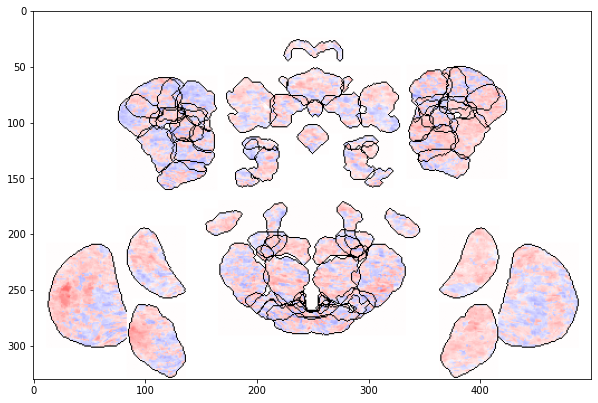

In [79]:
plt.figure(figsize=(10,10))
for i in range(24):
    print(i)
    plt.imshow(explosions[i][170:,:]) #this was made with cmap=hot
    fname = os.path.join(save_dir, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=300,bbox_inches='tight')